# 5. Modelling - Multivariate Time Series Models


## **Pips**

In [ ]:
# For auto_arima
#!pip install pmdarima

# For FbProphet
#!pip install pystan~=2.14
#!pip install fbprophet

#For PyCaret
# install slim version (default)
#!pip install pycaret  
#!pip install markupsafe==2.0.1  

## **Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import scale
from pandas.plotting import lag_plot
#set style for plots
sns.set_theme(style="whitegrid", palette='deep')

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
# Imports for models
from statsmodels.tsa.stattools import adfuller #Checking stationary
from sklearn.ensemble import RandomForestRegressor # For feature selection
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX # For ARIMAX, SARIMAX
#from sklearn.metrics import mean_absolute_percentage_error # Calculate Error
from sklearn.model_selection import TimeSeriesSplit # Cross-validation
#from pmdarima.arima import auto_arima # auto_arima
#from fbprophet import Prophet # FbProphet
from sklearn.model_selection import ParameterGrid # GridSearch
#from pycaret.regression import *

## **5.1 Loading Data**

In [ ]:
# Load csv file
url='https://github.com/hangulde/Air_Quality_Prediction_of_Boston-/raw/main/data/dataset_ready_for_EDA/all_features_eda.csv'
df = pd.read_csv(url, index_col='date')
df.index = pd.to_datetime(df.index) 
df = df[::-1]
df.head()

,pm25,day,month,year,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,...,flight_number,fuel_and_gas_total,special_fuel,gasoline,vehicle-miles,natural_gas,gasoline_sales,Population,Growth,GrowthRate
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,47.0,1,1,2014,-2.1,-7.0,-4.7,-6.6,-13.3,-10.0,...,24841.0,252971591.0,34329658.0,218641933.0,4547,53771,5561.6,662855,9853,0.0151
2014-01-02,47.0,2,1,2014,-3.3,-16.1,-8.4,-9.6,-28.2,-16.6,...,24841.0,252971591.0,34329658.0,218641933.0,4547,53771,5561.6,662855,9853,0.0151
2014-01-03,45.0,3,1,2014,-10.0,-17.0,-14.4,-18.0,-29.8,-24.9,...,24841.0,252971591.0,34329658.0,218641933.0,4547,53771,5561.6,662855,9853,0.0151
2014-01-04,38.0,4,1,2014,-3.0,-17.2,-9.7,-9.3,-25.4,-16.5,...,24841.0,252971591.0,34329658.0,218641933.0,4547,53771,5561.6,662855,9853,0.0151
2014-01-05,54.0,5,1,2014,3.0,-4.4,-0.7,2.0,-10.5,-4.7,...,24841.0,252971591.0,34329658.0,218641933.0,4547,53771,5561.6,662855,9853,0.0151


### **5.1.1 Prepare data for feature selection**



In [ ]:
# drop unrelated columns 
df.drop(columns=['day', 'month', 'year','Growth', 'GrowthRate', 'icon'], inplace=True)

In [ ]:
# investigate columns
print(df.shape)
df.columns

(2922, 27)


Index(['pm25', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipcover', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'flight_number', 'fuel_and_gas_total',
       'special_fuel', 'gasoline', 'vehicle-miles', 'natural_gas',
       'gasoline_sales', 'Population'],
      dtype='object')

### **5.1.2 Creating New Attributes**



In [ ]:
# create lags of attributes 
# I take the lags of daily data, not monthly or yearly data 
columns = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipcover', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility']
for col in columns:
    for i in range(1, 5): # 5 lags
        df["%s_%s_%s"%(col,i,-1)] = df[col].shift(i)

In [ ]:
df.tail(6)

,pm25,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure_3_-1,sealevelpressure_4_-1,cloudcover_1_-1,cloudcover_2_-1,cloudcover_3_-1,cloudcover_4_-1,visibility_1_-1,visibility_2_-1,visibility_3_-1,visibility_4_-1
date,,,,,,,,,,,,,,,,,,,,,
2021-12-26,64.0,3.4,1.2,2.2,-0.5,-5.1,-2.4,-1.2,79.24,6.07,...,1017.1,1002.8,99.8,100.0,34.0,80.9,7.8,15.2,16.0,13.0
2021-12-27,26.0,1.7,-1.1,0.5,1.7,-6.7,-3.4,-5.2,65.61,0.00,...,1019.9,1017.1,93.7,99.8,100.0,34.0,15.0,7.8,15.2,16.0
2021-12-28,27.0,7.2,0.7,3.9,4.2,-1.7,1.6,-0.7,74.15,1.21,...,1004.4,1019.9,71.0,93.7,99.8,100.0,16.0,15.0,7.8,15.2
2021-12-29,40.0,5.7,2.8,4.4,5.7,-0.1,3.1,-1.1,68.08,0.03,...,1008.1,1004.4,96.4,71.0,93.7,99.8,12.1,16.0,15.0,7.8
2021-12-30,42.0,5.7,3.3,4.6,5.7,0.8,3.2,2.6,87.69,1.50,...,1016.2,1008.1,99.5,96.4,71.0,93.7,16.0,12.1,16.0,15.0
2021-12-31,52.0,7.2,4.4,5.9,6.6,2.9,4.9,4.8,92.98,0.00,...,1010.0,1016.2,99.8,99.5,96.4,71.0,8.0,16.0,12.1,16.0


In [ ]:
df.shape

(2922, 99)

In [ ]:
# Save the df with all dates for MTS models
df_models = df 
pm25 = df['pm25']

In [ ]:
# Exclude test data (2021)
df = df.loc[:'2020-12-31']

In [ ]:
df.tail()

,pm25,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure_3_-1,sealevelpressure_4_-1,cloudcover_1_-1,cloudcover_2_-1,cloudcover_3_-1,cloudcover_4_-1,visibility_1_-1,visibility_2_-1,visibility_3_-1,visibility_4_-1
date,,,,,,,,,,,,,,,,,,,,,
2020-12-27,33.0,3.3,-3.9,-0.5,-0.2,-9.4,-4.9,-7.7,58.78,0.00,...,1023.1,1025.8,56.4,99.7,91.9,42.3,16.0,10.7,16.0,16.0
2020-12-28,46.0,9.4,-2.2,3.8,6.3,-5.7,0.7,0.2,77.79,0.00,...,1004.8,1023.1,31.2,56.4,99.7,91.9,16.0,16.0,10.7,16.0
2020-12-29,49.0,5.6,-3.9,0.9,1.2,-9.7,-4.6,-11.5,40.61,0.00,...,1007.8,1004.8,75.7,31.2,56.4,99.7,16.0,16.0,16.0,10.7
2020-12-30,25.0,4.4,-4.4,-0.7,-0.4,-10.8,-5.5,-10.0,50.51,0.00,...,1023.2,1007.8,31.9,75.7,31.2,56.4,16.0,16.0,16.0,16.0
2020-12-31,32.0,7.2,1.6,5.1,3.8,-2.4,1.1,-0.8,66.30,2.56,...,1021.8,1023.2,77.2,31.9,75.7,31.2,16.0,16.0,16.0,16.0


In [ ]:
# Drop NaNs
df.dropna(axis=0, inplace=True)

In [ ]:
# define target
X = df.drop('pm25', axis=1)
y = df['pm25']
# drop the target
df.drop('pm25', axis=1, inplace=True)

## **5.2 Feature Selection for Exogenous Variables**

### **5.2.1 Stepwise Regression - Backwards Elimination Approach**

In simple terms, stepwise regression is a process that helps determine which factors are important and which are not. Certain variables have a rather high p-value and were not meaningfully contributing to the accuracy of our prediction. From there, only important factors are kept to ensure that the linear model does its prediction based on factors that can help it produce the most accurate result [link](https://towardsdatascience.com/stepwise-regression-tutorial-in-python-ebf7c782c922).

In [ ]:
df.shape

(2553, 98)

In [ ]:
## getting column names
x_columns = list(df.columns)

In [ ]:
import statsmodels.api as sm

def get_stats():
    x = df[x_columns]
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                   pm25   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              487.1
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                        0.00
Time:                        19:01:00   Log-Likelihood:                         -9380.6
No. Observations:                2553   AIC:                                  1.896e+04
Df Residuals:                    2456   BIC:                                  1.952e+04
Df Model:                          97                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [ ]:
# create a list of variables whose  p > .40 (i decided 0.4 as a treshold)
delete_list1 = ['temp',
'dew',
'humidity',
'precip',
'snow',
'sealevelpressure',
'cloudcover',
'flight_number',
'fuel_and_gas_total',
'Population',
'tempmax_2_-1',
'tempmax_3_-1',
'tempmax_4_-1',
'tempmin_1_-1',
'feelslikemax_2_-1',
'feelslikemax_3_-1',
'feelslikemax_4_-1',
'feelslikemin_1_-1',
'feelslikemin_3_-1',
'feelslikemin_4_-1',
'feelslike_3_-1',
'dew_2_-1',
'dew_3_-1',
'dew_4_-1',
'humidity_3_-1',
'precip_2_-1',
'precip_3_-1',
'precip_4_-1',
'precipcover_2_-1',
'precipcover_4_-1',
'snow_2_-1',
'snow_3_-1',
'snow_4_-1',
'snowdepth_2_-1',
'snowdepth_3_-1',
'windgust_2_-1',
'windgust_3_-1',
'windgust_4_-1',
'windspeed_4_-1',
'winddir_2_-1',
'sealevelpressure_4_-1',
'visibility_2_-1',
'visibility_4_-1'
]

In [ ]:
x_columns = [e for e in x_columns if e not in delete_list1]

get_stats()

                                 OLS Regression Results                                
Dep. Variable:                   pm25   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              864.3
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                        0.00
Time:                        19:01:00   Log-Likelihood:                         -9394.0
No. Observations:                2553   AIC:                                  1.890e+04
Df Residuals:                    2498   BIC:                                  1.922e+04
Df Model:                          55                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [ ]:
# delete bigger than 0.2
delete_list2=['feelslikemin',
'snowdepth',
'windgust',
'winddir',
'feelslikemax_1_-1',
'feelslikemin_2_-1',
'precipcover_3_-1']

In [ ]:
x_columns = [e for e in x_columns if e not in delete_list2]

get_stats()

                                 OLS Regression Results                                
Dep. Variable:                   pm25   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              990.1
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                        0.00
Time:                        19:01:00   Log-Likelihood:                         -9397.6
No. Observations:                2553   AIC:                                  1.889e+04
Df Residuals:                    2505   BIC:                                  1.917e+04
Df Model:                          48                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [ ]:
delete_list3 = ['tempmin',
'precipcover ',
'feelslike_1_-1',
'humidity_1_-1',
'precip_1_-1',
'cloudcover_1_-1',]

In [ ]:
x_columns = [e for e in x_columns if e not in delete_list3]

get_stats()

                                 OLS Regression Results                                
Dep. Variable:                   pm25   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              1103.
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                        0.00
Time:                        19:01:00   Log-Likelihood:                         -9402.1
No. Observations:                2553   AIC:                                  1.889e+04
Df Residuals:                    2510   BIC:                                  1.914e+04
Df Model:                          43                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [ ]:
delete_list4 = ['precipcover',
'special_fuel',
'temp_4_-1',
'feelslike_4_-1',
'winddir_3_-1',
'cloudcover_4_-1',
'visibility_3_-1']

In [ ]:
x_columns = [e for e in x_columns if e not in delete_list4]

get_stats()

                                 OLS Regression Results                                
Dep. Variable:                   pm25   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              1313.
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                        0.00
Time:                        19:01:00   Log-Likelihood:                         -9410.0
No. Observations:                2553   AIC:                                  1.889e+04
Df Residuals:                    2517   BIC:                                  1.910e+04
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [ ]:
delete_list5 = ['sealevelpressure_3_-1']

In [ ]:
x_columns = [e for e in x_columns if e not in delete_list5]

get_stats()

                                 OLS Regression Results                                
Dep. Variable:                   pm25   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              1350.
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                        0.00
Time:                        19:01:00   Log-Likelihood:                         -9410.9
No. Observations:                2553   AIC:                                  1.889e+04
Df Residuals:                    2518   BIC:                                  1.910e+04
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [ ]:
len(x_columns)

35

In [ ]:
feature_set1 = x_columns

### **5.2.2 Random Forest**

In [ ]:
# Check the shape of attributes and target
print(X.shape)
print(y.shape)

(2553, 98)
(2553,)


In [ ]:
# Split the data into 40% test and 60% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [ ]:
# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the regressor
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

In [ ]:
features = {} # a dict to hold feature_name: feature_importance

for feature, importance in zip(df.columns, rf.feature_importances_):
    features[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(features, orient='index').rename(columns={0: 'Gini-importance'})

In [ ]:
importances = importances.sort_values(by=['Gini-importance'],ascending = False)

In [ ]:
importances['cum_imp'] = importances['Gini-importance'].cumsum()
importances['id'] = range(1, 99)
importances.head(50)

,Gini-importance,cum_imp,id
windspeed_1_-1,0.063946,0.063946,1
Population,0.045675,0.109621,2
windspeed_2_-1,0.036847,0.146468,3
tempmin_2_-1,0.032714,0.179183,4
feelslikemax_1_-1,0.030194,0.209377,5
tempmax_1_-1,0.030160,0.239537,6
temp_2_-1,0.026191,0.265728,7
feelslikemin_3_-1,0.025753,0.291481,8
tempmax_2_-1,0.023704,0.315185,9
dew_2_-1,0.022086,0.337271,10


In [ ]:
feature_set2 = importances.index[:27] # 60% of total importance
feature_set3 = importances.index[:37] # 70% of total importance

###  **5.2.3 Creating Feature Different Sets**

In [ ]:
print('Length of feature set 1 is', len(feature_set1))
print('Length of feature set 2 is', len(feature_set2))
print('Length of feature set 3 is', len(feature_set3))

Length of feature set 1 is 35
Length of feature set 2 is 27
Length of feature set 3 is 37


In [ ]:
# feature_set1 from stepwise regression 
final_feature_set1 = feature_set1
# feature_set2 from random forest 60% importance
final_feature_set2 = list(feature_set2)
# feature_set3 from random forest 70% importance
final_feature_set3 = list(feature_set3)
# UNION of set 1 and set 2
final_feature_set4 = list(set(list(set(feature_set1) | set(feature_set2))))
# UNION of set 1 and set 3
final_feature_set5 = list(set(list(set(feature_set1) | set(feature_set3))))
# INTERSECTION of set 1 and set2
final_feature_set6 = list(set(list(set(feature_set1) & set(feature_set2))))
# INTERSECTION of set 1 and set3
final_feature_set7 = list(set(list(set(feature_set1) & set(feature_set3))))

In [ ]:
# Number of features
for i in range(1,8):
  set_name = locals()['final_feature_set' + str(i)]
  print(f" final_feature_set {i} has {len(set_name)} features.")

 final_feature_set 1 has 35 features.
 final_feature_set 2 has 27 features.
 final_feature_set 3 has 37 features.
 final_feature_set 4 has 46 features.
 final_feature_set 5 has 53 features.
 final_feature_set 6 has 16 features.
 final_feature_set 7 has 19 features.


## **5.3 Checking Stationary for Exogenous Variables**

**Daily Data**

In [ ]:
# Define the function which shows non-stationary. 
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3)
    if p_value >= sig:
      print(f" {name} : P-Value = {p_value} => Non-stationary.") 

In [ ]:
# try all features with 2014-2021
for name, column in df_models.diff(1).dropna().iteritems():
    adfuller_test(column, name=column.name)

# output is nothing 

**Note:** diff(1) makes all daily attributes stationary.

**Monthly Data**

In [ ]:
# Use addfuller_test function for monthly data (diff(2)) 
for name, column in df_models.resample(rule='MS').mean().diff(2).dropna().iteritems():
    adfuller_test(column, name=column.name)

 fuel_and_gas_total : P-Value = 0.073 => Non-stationary.
 gasoline : P-Value = 0.08 => Non-stationary.
 vehicle-miles : P-Value = 0.151 => Non-stationary.
 Population : P-Value = 0.822 => Non-stationary.


In [ ]:
for col in ['fuel_and_gas_total', 'gasoline', 'vehicle-miles', 'Population']:
  for i in range(1,8):
    set_name = locals()['final_feature_set' + str(i)]
    if set_name.count(col) == 1:
      print(f" {col} is in final_feature_set{i}.")

 gasoline is in final_feature_set1.
 gasoline is in final_feature_set4.
 gasoline is in final_feature_set5.
 vehicle-miles is in final_feature_set1.
 vehicle-miles is in final_feature_set4.
 vehicle-miles is in final_feature_set5.
 Population is in final_feature_set2.
 Population is in final_feature_set3.
 Population is in final_feature_set4.
 Population is in final_feature_set5.


## **5.4 Multivariate Time Series Models**



**Preparing dataframe - Monthly Data- for MTS models**



In [ ]:
df_models.dropna(axis=0, inplace=True) 
# From 2014-01-05 to 2021-12-31
df_models.shape

(2918, 99)

In [ ]:
# RENAME monthly data for using in MTS models (df_models_m)
df_models_m = df_models.resample(rule='MS').mean()
df_models_m.head()

,pm25,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure_3_-1,sealevelpressure_4_-1,cloudcover_1_-1,cloudcover_2_-1,cloudcover_3_-1,cloudcover_4_-1,visibility_1_-1,visibility_2_-1,visibility_3_-1,visibility_4_-1
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,54.407407,2.229630,-5.429630,-1.770370,-1.203704,-12.174074,-6.825926,-8.870370,61.287037,2.511852,...,1014.377778,1014.511111,63.266667,65.018519,66.611111,65.455556,13.307407,13.022222,12.559259,12.559259
2014-02-01,53.892857,1.600000,-5.200000,-1.757143,-1.646429,-11.178571,-6.700000,-9.353571,59.211071,3.193929,...,1017.275000,1017.607143,66.460714,64.239286,64.350000,65.092857,13.746429,13.796429,13.750000,13.750000
2014-03-01,48.032258,5.090323,-3.545161,0.616129,2.290323,-9.296774,-3.761290,-8.693548,53.158710,3.496129,...,1015.929032,1015.770968,64.222581,63.341935,62.493548,61.125806,14.738710,15.029032,15.158065,15.167742
2014-04-01,38.366667,12.960000,4.920000,8.686667,11.946667,1.573333,6.613333,0.696667,60.587667,2.607000,...,1015.753333,1015.920000,67.066667,67.066667,67.300000,67.283333,14.996667,14.650000,14.516667,14.526667
2014-05-01,35.709677,18.509677,10.770968,14.477419,18.361290,9.780645,14.167742,7.267742,65.682903,2.279032,...,1016.383871,1016.251613,72.887097,73.906452,74.761290,74.883871,14.574194,14.590323,14.593548,14.787097


In [ ]:
# Create a df for exogeneous variables 
df_exog = df_models_m.drop(columns=['pm25'])
# Create a df for our target
X = df_models_m[['pm25']]

In [ ]:
# Split the data train, validation and test data.

X_train =  X.loc[:'2018-12-01'] # First 5 years
X_validation = X.loc['2019-01-01': '2020-12-01'] # 2 years after train data
X_tr_val= X.loc[:'2020-12-01'] # both train and validation
X_test = X.loc['2021-01-01': '2021-12-01'] # Test data

df_exog_train =  df_exog.loc[:'2018-12-01'] # First 5 years
df_exog_validation = df_exog.loc['2019-01-01': '2020-12-01'] # 2 years after train data
df_exog_tr_val= df_exog.loc[:'2020-12-01'] # both train and validation
df_exog_test = df_exog.loc['2021-01-01': '2021-12-01'] # Test data


## **5.4.1 ARIMAX**

For determining order (p, d, q), I will use different methods.

* Use just one train (5 years) and validation (2 years)
* Use TimeSeriesSplit for cross validation. Start forecasting with 5 years of train and just 1 month forecast.
* auto_arima() function

I will define two functions:
* **get_mape_tr_test()**: Calculates MAPE with train(tr+validation) and test set.
* **plot_forecast()**: plotting the forecast that were built with get_mape_tr_test function

In [ ]:
# define a function for calculating MAPE with train(tr+validation) and test set
def get_mape_tr_test(feature_set, order=(0,0,0), seasonal_order=(0,0,0,0)):
          
    # define and fit the model
    model = SARIMAX(X_tr_val, exog=df_exog_tr_val[feature_set], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    # predict the train data
    pred = model_fit.predict()[10:]
    forecast = model_fit.forecast(len(X_test), exog=df_exog_test[feature_set])
    # return the MAPE on our prediction
    print(f"MAPE for model with {len(feature_set)} exogenious features and {order} is {round(mean_absolute_percentage_error(X_test, forecast), 3)}")

In [ ]:
def plot_forecast(feature_set, order=(0,0,0), seasonal_order=(0,0,0,0)):
  model_fit = SARIMAX(X_tr_val, exog=df_exog_tr_val[feature_set], order=order, seasonal_order=seasonal_order).fit()
  pred = model_fit.predict()[10:] # predict the train data
  forecast = model_fit.forecast(len(X_test), exog=df_exog_test[feature_set]) # forecast for test data
  print(f"MAPE for model with {len(feature_set)} exogenious features and {order} is {round(mean_absolute_percentage_error(X_test, forecast), 3)}")
  plt.figure(figsize=(10,5))
  plt.plot(X_tr_val.index, X_tr_val, label='Train Data')
  plt.plot(X_test.index, X_test, label='Test Data')
  plt.plot(X_tr_val.index[10:], pred, label='Predicted Data')
  plt.plot(X_test.index, forecast, label='Forecasted Data')
  plt.legend(loc='best')
  plt.xticks(rotation='vertical')
  plt.title(f'SARIMAX Model for Monthly Data')
  plt.legend(bbox_to_anchor=(1.5, 1.05))
  plt.show()

### **5.4.1 Create a loop for order just one train & validation set**

In [ ]:
# Loop for defining order
order_aic_bic_mape = []
for i in range(8):
  set_name = locals()['final_feature_set' + str(i)]
  for p in range(6):
    for q in range(6):
      for d in [2,3]:
          try:
            model = SARIMAX(X_train, exog=df_exog_train[set_name], order=(p,d,q))
            results = model.fit()
            pred = results.forecast(len(X_validation), exog=df_exog_validation[set_name])
            order_aic_bic_mape.append((p, d, q, len(set_name), results.aic, results.bic, mean_absolute_percentage_error(X_validation, pred)))
          except:
            order_aic_bic_mape.append((p, d, q, len(set_name), None, None, None))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
order_df = pd.DataFrame(order_aic_bic_mape, columns=['p', 'd', 'q', 'i', 'aic' ,'bic', 'mape'])

In [ ]:
order_df.sort_values(by='mape').head(5)

The best parameters for (p,d,q)) are (5,2,2) with final_featureset_2.

MAPE for model with 27 exogenious features and (5, 2, 2) is 0.206


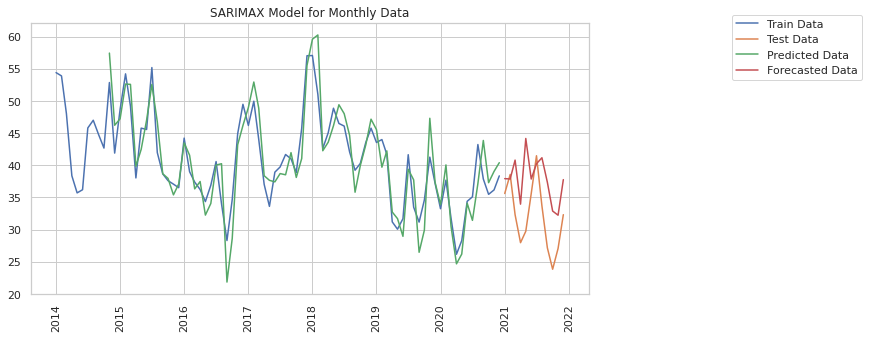

In [ ]:
plot_forecast(final_feature_set2, order=(5,2,2))

### **5.4.2 Find best order with TimeSeriesSplit**

In [ ]:
# Create a dataframe with datetime index
# Exclude test dataset (2021)
df_cv = df_models_m.loc[:'2020-12-01']
# check
df_cv.head()

,pm25,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure_3_-1,sealevelpressure_4_-1,cloudcover_1_-1,cloudcover_2_-1,cloudcover_3_-1,cloudcover_4_-1,visibility_1_-1,visibility_2_-1,visibility_3_-1,visibility_4_-1
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,54.407407,2.229630,-5.429630,-1.770370,-1.203704,-12.174074,-6.825926,-8.870370,61.287037,2.511852,...,1014.377778,1014.511111,63.266667,65.018519,66.611111,65.455556,13.307407,13.022222,12.559259,12.559259
2014-02-01,53.892857,1.600000,-5.200000,-1.757143,-1.646429,-11.178571,-6.700000,-9.353571,59.211071,3.193929,...,1017.275000,1017.607143,66.460714,64.239286,64.350000,65.092857,13.746429,13.796429,13.750000,13.750000
2014-03-01,48.032258,5.090323,-3.545161,0.616129,2.290323,-9.296774,-3.761290,-8.693548,53.158710,3.496129,...,1015.929032,1015.770968,64.222581,63.341935,62.493548,61.125806,14.738710,15.029032,15.158065,15.167742
2014-04-01,38.366667,12.960000,4.920000,8.686667,11.946667,1.573333,6.613333,0.696667,60.587667,2.607000,...,1015.753333,1015.920000,67.066667,67.066667,67.300000,67.283333,14.996667,14.650000,14.516667,14.526667
2014-05-01,35.709677,18.509677,10.770968,14.477419,18.361290,9.780645,14.167742,7.267742,65.682903,2.279032,...,1016.383871,1016.251613,72.887097,73.906452,74.761290,74.883871,14.574194,14.590323,14.593548,14.787097


#### **5.4.2.1 For casting just one month with TimeSeriesSplit**

In [ ]:
# Use train data for model, test it with just month. Get average of 24 months.

tscv = TimeSeriesSplit(n_splits = 24, test_size=1) # forecast just one month

ave_mape = [] # List for average mape for each cv
for i in range(1,8):
  set_name = locals()['final_feature_set' + str(i)]
  for p in range(1, 3):
    for q in range(1,3):
      for d in [2,3]:
        mape = [] # append all errors of cross-validation
        for train_index, test_index in tscv.split(df_cv):
          X_train_cv, X_test_cv, = df_cv.pm25.iloc[train_index], df_cv.pm25.iloc[test_index]
          exo_train, exo_test = df_cv[set_name].iloc[train_index], df_cv[set_name].iloc[test_index]
          model = SARIMAX(X_train_cv, exog=exo_train, order=(p,d,q)).fit()
          pred = model.forecast(1, exog=exo_test)
          mape.append(mean_absolute_percentage_error(X_test_cv, pred))
          ave_mape.append((p, d, q, len(set_name), np.mean(mape)))

In [ ]:
# create a dataframe ave_mape list
order = pd.DataFrame(ave_mape, columns=['p', 'd','q', 'i', 'mape'])

In [ ]:
# See the 5 lowest MAPE
order.sort_values(by='mape', ascending=True).head()

,p,d,q,i,mape
1224,1,3,2,19,0.014458
1320,2,3,2,19,0.016013
480,2,2,1,37,0.019753
1152,1,2,1,19,0.020461
336,2,2,2,27,0.021327


In [ ]:
# find mape
get_mape_tr_test(final_feature_set7, order=(1,3,2))

MAPE for model with feature set with 19 and (1, 3, 2) is 0.518494794359864


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The average MAPEs for one monthly forecast is so low. When I use these parameters for 12 months forecasting MAPE increase dramatically. So I don't use this order for forecasting.

#### **5.4.2.2 For casting just 6 months with TimeSeriesSplit**

In [ ]:
tscv = TimeSeriesSplit(n_splits = 4, test_size=6) # forecast 6 months

ave_mape = [] # List for average mape for each cv
for i in range(1, 8):
  set_name = locals()['final_feature_set' + str(i)]
  for p in range(4):
    for q in range(4):
      for d in [2, 3]:
        mape = [] # append all errors of cross-validation
        for train_index, test_index in tscv.split(df_cv):
          X_train_cv, X_test_cv, = df_cv.pm25.iloc[train_index], df_cv.pm25.iloc[test_index]
          exo_train, exo_test = df_cv[set_name].iloc[train_index], df_cv[set_name].iloc[test_index]
          model = SARIMAX(X_train_cv, exog=exo_train, order=(p,d,q)).fit()
          pred = model.forecast(6, exog=exo_test)
          mape.append(mean_absolute_percentage_error(X_test_cv, pred))
          ave_mape.append((len(set_name), p, d, q, np.mean(mape)))

In [ ]:
order = pd.DataFrame(ave_mape, columns=['p', 'd','q', 'i', 'mape'])

In [ ]:
df_sort = order.sort_values(by='mape', ascending=True).head()
df_sort

,p,d,q,i,mape
1208,1,2,2,19,0.051900
1392,5,2,5,19,0.054843
1256,2,2,3,19,0.055545
1056,2,2,3,16,0.057675
1296,3,2,3,19,0.062309


In [ ]:
# MAPE for model with order=(1,2,2) set 7

my_dict = {'sets': [final_feature_set7,final_feature_set7,final_feature_set7,final_feature_set6,final_feature_set7], 
           'orders': [(1,2,2), (5,2,5), (2,2,3), (2,2,3), (3,2,3)]}

for my_set, my_order in zip(my_dict['sets'], my_dict['orders']):
  get_mape_tr_test(my_set, order=my_order)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE for model with feature set with 19 and (1, 2, 2) is 0.24
MAPE for model with feature set with 19 and (5, 2, 5) is 0.252
MAPE for model with feature set with 19 and (2, 2, 3) is 0.189
MAPE for model with feature set with 16 and (2, 2, 3) is 0.227
MAPE for model with feature set with 19 and (3, 2, 3) is 0.163


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

MAPE for model with 19 exogenious features and (1, 2, 2) is 0.24


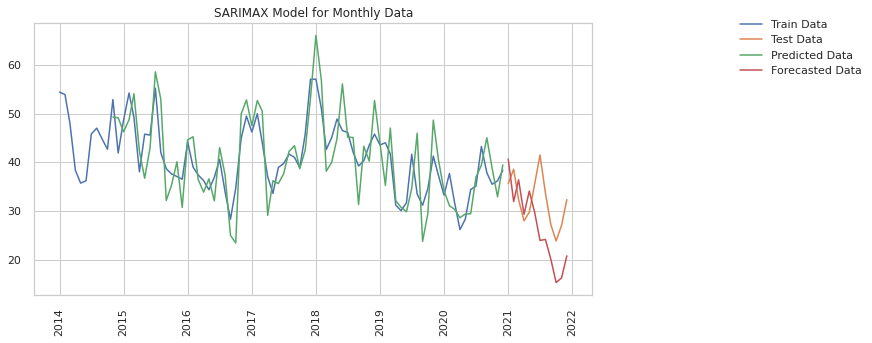

In [ ]:
plot_forecast(final_feature_set7, order=(1, 2, 2))

### **5.4.3 Auto_ARIMA**

In [ ]:
for i in range(1,8):
  set_name = locals()['final_feature_set' + str(i)]
  print(f"Final_feature_set{i}")
  model = auto_arima(X_train, X=df_exog_train[set_name], 
                    d=2, max_d=3,
                    max_p=6, # max value of p to test
                    max_q=6, # max value of q to test
                    seasonal = False,
                    stationary = False,
                    trace=True, error_action="ignore")

In [ ]:
# Try best orders with all final_feature_sets
my_dict = {'sets': [final_feature_set1,final_feature_set2,final_feature_set3,final_feature_set4,final_feature_set5,final_feature_set6,final_feature_set7], 
           'orders': [(1,2,2), (0,2,0), (2,2,2), (5,2,0), (3,2,0), (0,2,2), (0,2,2)]}
for my_set, my_order in zip(my_dict['sets'], my_dict['orders']):
  get_mape_tr_test(my_set, order=my_order)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE for model with feature set with 35 and (1, 2, 2) is 0.648957133277459
MAPE for model with feature set with 27 and (0, 2, 0) is 0.10618199028077673
MAPE for model with feature set with 37 and (2, 2, 2) is 0.19729786847816289


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE for model with feature set with 46 and (5, 2, 0) is 0.19660507985353218


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE for model with feature set with 53 and (3, 2, 0) is 0.2640666887750041
MAPE for model with feature set with 16 and (0, 2, 2) is 0.18970255437724348
MAPE for model with feature set with 19 and (0, 2, 2) is 0.25011609351608244


MAPE for model with 27 exogenious features and (0, 2, 0) is 0.106


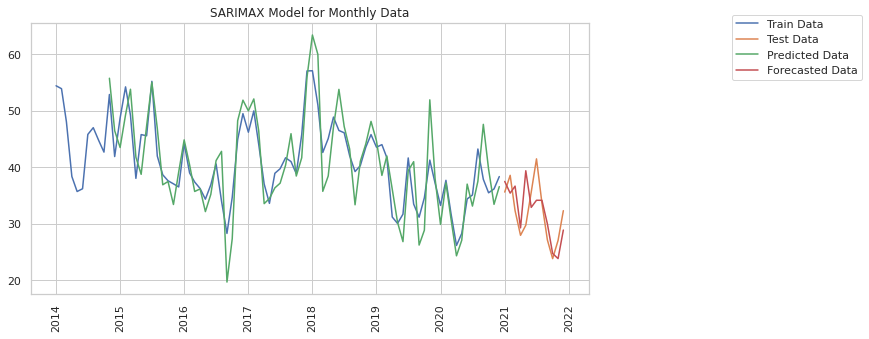

In [ ]:
plot_forecast(final_feature_set2, order=(0,2,0))

## **5.5 SARIMAX**

For determining order (p, d, q) and (ps,ds,qs,m) I will use different methods.

* Use just one train (5 years) and validation (2 years)
* Use TimeSeriesSplit for cross validation. Start forecasting with 5 years of train and just 1 month forecast.
* auto_arima() function

I will define a function:

**get_mape():** Calculates MAPE with diffent dataset. I can't use get_mape_tr_test function because X_train and X_test is pre-defined. 

In [ ]:
# define get_mape function for train and validation split
def get_mape(feature_set, order=(0,0,0), seasonal_order=(0,0,0,0)):
          
    # define and fit the model
    model = SARIMAX(X_train, exog=df_exog_train[feature_set], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    # predict the future!
    pred = model_fit.forecast(len(X_validation), exog=df_exog_validation[feature_set])
    
    # return the MAPE on our prediction
    return mean_absolute_percentage_error(X_validation, pred)

#### ***5.5.1 Create a loop for order just one train & validation set***

In [ ]:
# define a function for getting order
order_aic_bic_mape2 = [] # holds model parameters, feature_set_name and MAPEs
def get_order (abc):
    # nested loop through all parameters.  
    for p in range(0,3):
        for d in range(0,3):  
            for q in range(0,3):
                for ps in range(0,2):
                    for ds in range(0,2):
                        for qs in range(0,2):
                          try:
                            mape = get_mape(abc, order=(p,d,q), seasonal_order=(ps,ds,qs,12))
                            order_aic_bic_mape2.append((len(abc), p, d, q, ps,ds,qs, mape, results.aic, results.bic))
                          except:
                            order_aic_bic_mape2.append((len(abc), p, d, q, ps,ds,qs, mape, results.aic, results.bic)
                                (p, d, q, len(set_name), mape, None, None))    

In [ ]:
for i in range(1,8):
  set_name = locals()['final_feature_set' + str(i)]
  get_order(set_name)

In [ ]:
order_df = pd.DataFrame(order_aic_bic_mape2, columns=['i','p', 'd', 'q', 'ps','ds','qs', 'mape', 'aic' ,'bic', ])

In [ ]:
order_df.sort_values(by='mape', ascending=True).head()

,i,p,d,q,ps,ds,qs,mape,aic,bic
404,27,2,1,2,1,0,0,0.099895,529.522668,603.698616
400,27,2,1,2,0,0,0,0.102366,529.522668,603.698616
1365,19,0,2,2,1,0,1,0.113569,529.522668,603.698616
1433,19,1,2,2,0,0,1,0.114650,529.522668,603.698616
401,27,2,1,2,0,0,1,0.115052,529.522668,603.698616


MAPE for model with 27 exogenious features and (2, 1, 2) is 0.211


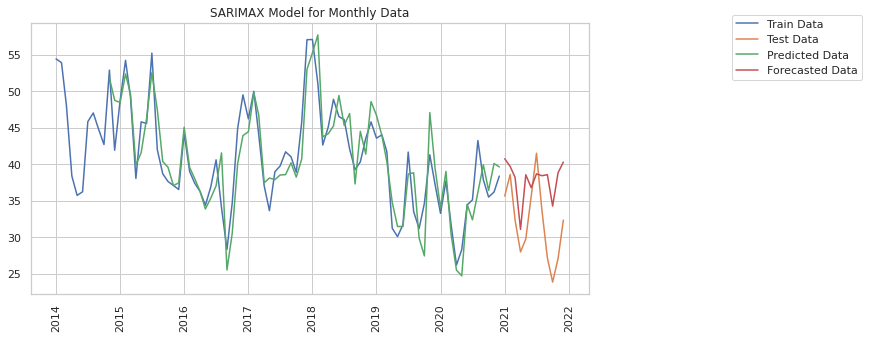

In [ ]:
plot_forecast(final_feature_set2, order=(2,1,2), seasonal_order=(1,0,0,12))

### **5.5.2 Find best order with TimeSeriesSplit**

In [ ]:
# Create a dataframe with datetime index
# Exclude test dataset (2021)
df_cv = df_models_m.loc[:'2020-12-01']

#### **5.5.2.1 TimeSeriesSplit Six Months with Feature Set 2**

In [ ]:
tscv = TimeSeriesSplit(n_splits = 4, test_size=6) # forecast 6 months

ave_mape = [] # List for average mape for each cv
for p in range(4):
  for q in range(4):
    for d in [2,3]:
      for ps in range(0,2):
        for ds in range(0,2):
          for qs in range(0,2):
            mape = [] # append all errors of cross-validation
            for train_index, test_index in tscv.split(df_cv):
              X_train_cv, X_test_cv, = df_cv.pm25.iloc[train_index], df_cv.pm25.iloc[test_index]
              exo_train, exo_test = df_cv[final_feature_set2].iloc[train_index], df_cv[final_feature_set2].iloc[test_index]
              model = SARIMAX(X_train_cv, exog=exo_train, order=(p,d,q), seasonal_order = (ps, ds, qs,12)).fit()
              pred = model.forecast(6, exog=exo_test)
              mape.append(mean_absolute_percentage_error(X_test_cv, pred))
              ave_mape.append((p, d, q, ps, ds, qs, np.mean(mape)))

In [ ]:
order = pd.DataFrame(ave_mape, columns=['p', 'd','q','ps', 'ds', 'qs', 'mape'])

In [ ]:
order.sort_values(by='mape', ascending=True).head(10)


,p,d,q,ps,ds,qs,mape
96,0,3,1,0,0,0,0.062691
144,0,2,2,1,0,0,0.064629
452,1,2,3,0,0,1,0.065323
128,0,2,2,0,0,0,0.065404
148,0,2,2,1,0,1,0.066045
112,0,3,1,1,0,0,0.066727
132,0,2,2,0,0,1,0.068041
800,3,3,0,0,0,0,0.068591
480,1,3,3,0,0,0,0.069251
964,3,2,3,0,0,1,0.070344


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE for model with 27 exogenious features and (0, 3, 1) is 0.256


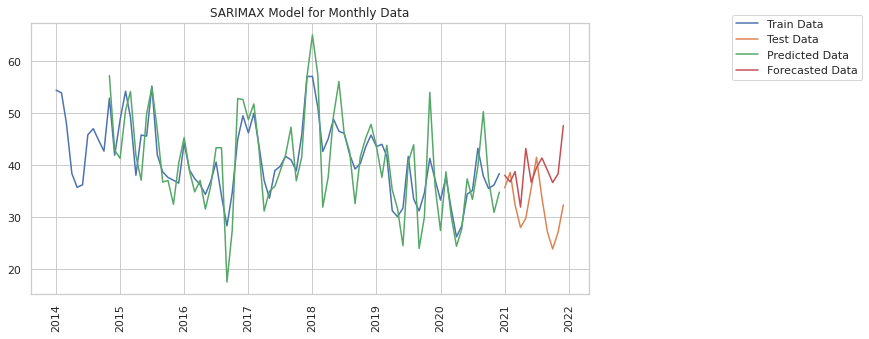

In [ ]:
plot_forecast(final_feature_set2, order=(0,3,1), seasonal_order=(0,0,0,12))

#### **5.5.2.2 TimeSeriesSplit Six Months with Feature Set 7**

In [ ]:
tscv = TimeSeriesSplit(n_splits = 4, test_size=6) # forecast 6 months

ave_mape = [] # List for average mape for each cv
for p in range(4):
  for q in range(4):
    for d in [2,3]:
      for ps in range(0,2):
        for ds in range(0,2):
          for qs in range(0,2):
            mape = [] # append all errors of cross-validation
            for train_index, test_index in tscv.split(df_cv):
              X_train_cv, X_test_cv, = df_cv.pm25.iloc[train_index], df_cv.pm25.iloc[test_index]
              exo_train, exo_test = df_cv[final_feature_set7].iloc[train_index], df_cv[final_feature_set7].iloc[test_index]
              model = SARIMAX(X_train_cv, exog=exo_train, order=(p,d,q), seasonal_order = (ps, ds, qs,12)).fit()
              pred = model.forecast(6, exog=exo_test)
              mape.append(mean_absolute_percentage_error(X_test_cv, pred))
              ave_mape.append((p, d, q, ps, ds, qs, np.mean(mape)))

In [ ]:
order = pd.DataFrame(ave_mape, columns=['p', 'd','q','ps', 'ds', 'qs', 'mape'])

In [ ]:
order.sort_values(by='mape', ascending=True).head(10)

,p,d,q,ps,ds,qs,mape
148,0,2,2,1,0,1,0.033433
388,1,2,2,0,0,1,0.036336
132,0,2,2,0,0,1,0.040301
404,1,2,2,1,0,1,0.040416
400,1,2,2,1,0,0,0.042847
724,2,2,3,1,0,1,0.048844
720,2,2,3,1,0,0,0.049566
144,0,2,2,1,0,0,0.049710
384,1,2,2,0,0,0,0.051923
128,0,2,2,0,0,0,0.054319


MAPE for model with 19 exogenious features and (1, 2, 2) is 0.149


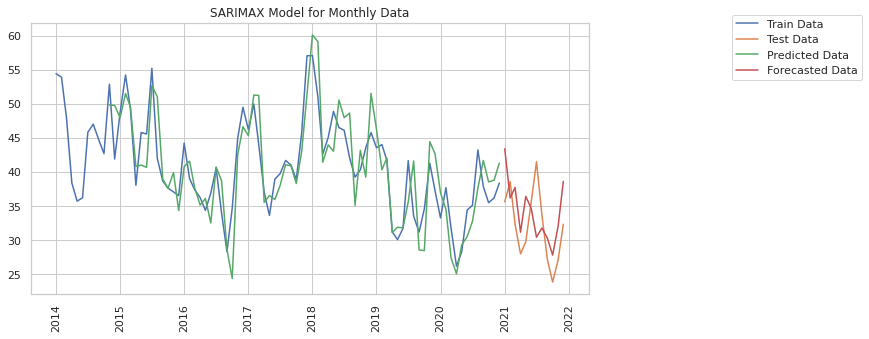

In [ ]:
plot_forecast(final_feature_set7, order=(1,2,2), seasonal_order=(0,0,1,12))

### **5.5.3 Auto_ARIMA**

***With final_feature_set_2***

In [ ]:
model = auto_arima(X_tr_val, X=df_exog_tr_val[final_feature_set2], 
                    d=2, max_d=3,
                    m=12,
                    start_P=1, start_Q=1, max_P=1, max_Q=1, 
                    max_p=6, # max value of p to test
                    max_q=6, # max value of q to test
                    seasonal = True,
                    stationary = False,
                    trace=True, error_action="ignore")

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=516.740, Time=10.24 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=813.025, Time=0.21 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=533.017, Time=3.21 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=536.520, Time=1.58 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=517.548, Time=2.64 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=504.023, Time=2.22 sec
 ARIMA(2,2,2)(0,0,0)[12]             : AIC=501.681, Time=1.18 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=557.852, Time=0.57 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=509.334, Time=2.21 sec
 ARIMA(3,2,2)(0,0,0)[12]             : AIC=613.577, Time=1.89 sec
 ARIMA(2,2,3)(0,0,0)[12]             : AIC=498.302, Time=1.66 sec
 ARIMA(2,2,3)(1,0,0)[12]             : AIC=504.314, Time=2.45 sec
 ARIMA(2,2,3)(0,0,1)[12]             : AIC=517.708, Time=1.95 sec
 ARIMA(2,2,3)(1,0,1)[12]             : AIC=511.166, Time=3.57 sec
 ARIMA(1,2,3)(0,0,0)[12]        

MAPE for model with 27 exogenious features and (2, 2, 3) is 0.205


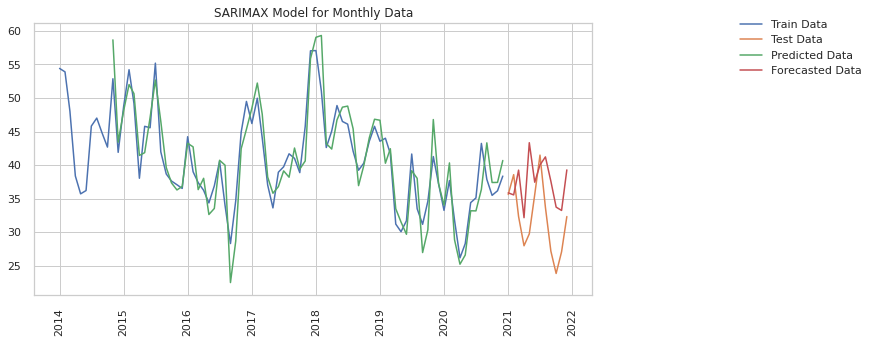

In [ ]:
plot_forecast(final_feature_set2, order = (2,2,3), seasonal_order=(0,0,0,12))

***With final_feature_set_7***

In [ ]:
model = auto_arima(X_tr_val, X=df_exog_tr_val[final_feature_set7], 
                    d=2, max_d=3,
                    start_P=1, start_Q=1, max_P=1, max_Q=1,
                    m=12,
                    max_p=6, # max value of p to test
                    max_q=6, # max value of q to test
                    seasonal = True,
                    stationary = False,
                    trace=True, error_action="ignore")

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=506.415, Time=5.92 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=820.703, Time=0.17 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=535.709, Time=1.68 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=522.136, Time=1.66 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=503.514, Time=3.22 sec
 ARIMA(2,2,2)(0,0,0)[12]             : AIC=502.738, Time=1.02 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=504.114, Time=2.05 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=552.218, Time=0.45 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=510.447, Time=0.86 sec
 ARIMA(3,2,2)(0,0,0)[12]             : AIC=509.922, Time=1.62 sec
 ARIMA(2,2,3)(0,0,0)[12]             : AIC=504.621, Time=1.74 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=503.549, Time=1.74 sec
 ARIMA(1,2,3)(0,0,0)[12]             : AIC=536.029, Time=1.40 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=518.639, Time=2.59 sec
 ARIMA(3,2,3)(0,0,0)[12]         

MAPE for model with 19 exogenious features and (2, 2, 2) is 0.225


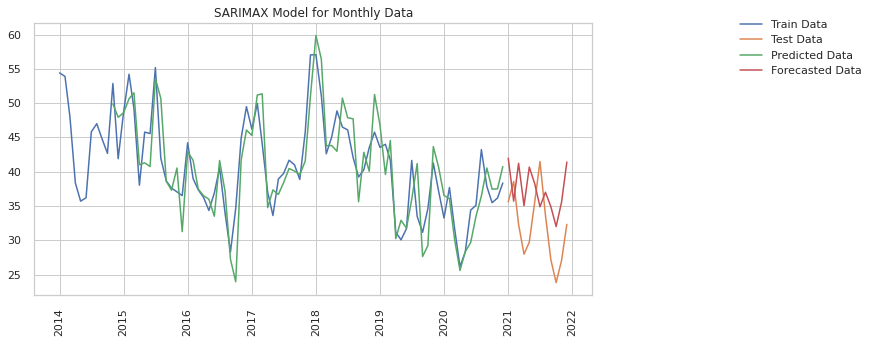

In [ ]:
plot_forecast(final_feature_set7, order = (2,2,2), seasonal_order=(0,0,0,12))

## **5.6 Facebook Prophet**

I will built FbProphet model with various ways.

* Model with default settings
* Grid search with different three parameters
* Grid search with different three parameters and cross-validation with TimeSeriesSplit

**Prepare Monthly Data**

In [ ]:
df_fb_m = df_models.resample(rule='MS').mean()

In [ ]:
# Prepare data for model
df_fb_m = df_fb_m.reset_index().rename({'date':'ds', 'pm25':'y'}, axis = 'columns')

In [ ]:
df_fb_m.head()

,ds,y,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,sealevelpressure_3_-1,sealevelpressure_4_-1,cloudcover_1_-1,cloudcover_2_-1,cloudcover_3_-1,cloudcover_4_-1,visibility_1_-1,visibility_2_-1,visibility_3_-1,visibility_4_-1
0,2014-01-01,54.407407,2.229630,-5.429630,-1.770370,-1.203704,-12.174074,-6.825926,-8.870370,61.287037,...,1014.377778,1014.511111,63.266667,65.018519,66.611111,65.455556,13.307407,13.022222,12.559259,12.559259
1,2014-02-01,53.892857,1.600000,-5.200000,-1.757143,-1.646429,-11.178571,-6.700000,-9.353571,59.211071,...,1017.275000,1017.607143,66.460714,64.239286,64.350000,65.092857,13.746429,13.796429,13.750000,13.750000
2,2014-03-01,48.032258,5.090323,-3.545161,0.616129,2.290323,-9.296774,-3.761290,-8.693548,53.158710,...,1015.929032,1015.770968,64.222581,63.341935,62.493548,61.125806,14.738710,15.029032,15.158065,15.167742
3,2014-04-01,38.366667,12.960000,4.920000,8.686667,11.946667,1.573333,6.613333,0.696667,60.587667,...,1015.753333,1015.920000,67.066667,67.066667,67.300000,67.283333,14.996667,14.650000,14.516667,14.526667
4,2014-05-01,35.709677,18.509677,10.770968,14.477419,18.361290,9.780645,14.167742,7.267742,65.682903,...,1016.383871,1016.251613,72.887097,73.906452,74.761290,74.883871,14.574194,14.590323,14.593548,14.787097


In [ ]:
# Split train-test data
train = df_fb_m[df_fb_m['ds'] < pd.Timestamp('2021-01-01')]
test = df_fb_m[df_fb_m['ds'] >= pd.Timestamp('2021-01-01')]

#### **5.6.1 FbProphet Model with Default Settings**

In [ ]:
# build the model
model = Prophet() 
for feature in final_feature_set7:
  model.add_regressor(feature)
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Create new df from 2014 to 2021
future_dates = model.make_future_dataframe(periods = len(test), freq = 'MS')

In [ ]:
# Add all exogenous features to future dates as a column
for feature in final_feature_set4:
  future_dates[feature]=df_fb_m[feature]

In [ ]:
future_dates.shape

(96, 47)

In [ ]:
prediction = model.predict(future_dates)

In [ ]:
prediction[['ds', 'yhat', 'yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-01,52.745638,48.331300,57.160169
1,2014-02-01,49.687892,44.827263,54.311395
2,2014-03-01,50.334116,46.322343,54.695969
3,2014-04-01,39.787671,35.394506,44.330232
4,2014-05-01,36.758848,32.210497,41.096491
...,...,...,...,...
91,2021-08-01,33.528974,28.771685,38.172153
92,2021-09-01,24.012713,19.521436,28.237405
93,2021-10-01,28.383946,24.066950,32.691007
94,2021-11-01,35.062516,30.424203,39.623222


In [ ]:
# Evaluate the model based on MAPE

pred = prediction.iloc[-len(test):]['yhat']
actual = test['y']
print(f'Mean Absolute Percentage Error = {mean_absolute_percentage_error(actual, pred)}')

Mean Absolute Percentage Error = 0.1508940220533018


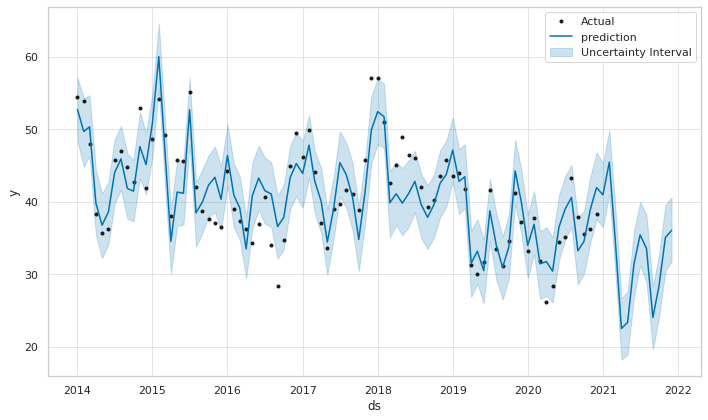

In [ ]:
model.plot(prediction)
plt.legend(['Actual', 'prediction', 'Uncertainty Interval'])
plt.show()

#### **5.6.2 FbProphet Model Tuning with Just One Validation Set**

In [ ]:
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [50, 100, 150,200]} #the number of change happen in the data
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
  cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 40


In [ ]:
# Create train and validation (test) dataset for hptuning
train = df_fb_m[df_fb_m['ds'] < pd.Timestamp('2019-01-01')] # train from 2014 to 2018 
test = df_fb_m[(df_fb_m['ds'] >= pd.Timestamp('2019-01-01')) & (df_fb_m['ds'] < pd.Timestamp('2021-01-01'))] # validation 2019-2020

In [ ]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

In [ ]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         yearly_seasonality = True, 
                         interval_width=0.95)
    for feature in final_feature_set3:
      model.add_regressor(feature)
    model.fit(train)
    future_dates = model.make_future_dataframe(periods = len(test), freq='MS')
    for feature in final_feature_set3:
      future_dates[feature]=df_fb_m[feature]
    prediction = model.predict(future_dates)
    pred = prediction.iloc[-len(test):]['yhat']
    actual = test['y']
    MAPE = mean_absolute_percentage_error(actual, pred)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,0.499016,"{'changepoint_prior_scale': 0.4, 'n_changepoin..."
1,0.499016,"{'changepoint_prior_scale': 0.4, 'n_changepoin..."
2,0.499016,"{'changepoint_prior_scale': 0.4, 'n_changepoin..."
3,0.499016,"{'changepoint_prior_scale': 0.4, 'n_changepoin..."
4,0.708920,"{'changepoint_prior_scale': 0.5, 'n_changepoin..."


In [ ]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.4,
 'n_changepoints': 150,
 'seasonality_mode': 'multiplicative'}

In [ ]:
# Split train-test data
train = df_fb_m[df_fb_m['ds'] < pd.Timestamp('2021-01-01')] # First 7 years
test = df_fb_m[df_fb_m['ds'] >= pd.Timestamp('2021-01-01')] # Last year

In [ ]:
model = Prophet(changepoint_prior_scale = 0.4,
                         n_changepoints = 150,
                         seasonality_mode = 'multiplicative',
                         yearly_seasonality = True, 
                         interval_width=0.95)
for feature in final_feature_set3:
      model.add_regressor(feature)
model.fit(train)
future_dates = model.make_future_dataframe(periods = len(test), freq='MS')
for feature in final_feature_set3:
      future_dates[feature]=df_fb_m[feature]
prediction = model.predict(future_dates)
pred = prediction.iloc[-len(test):]['yhat']
actual = test['y']
print(mean_absolute_percentage_error(actual, pred))

0.18532666919376314


### **5.6.3 FbProphet Model Tuning with TimeSeriesSplit**


In [ ]:
df_tscv = df_fb_m.loc[:83]

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [47, 100]} #the number of change happen in the data
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
  cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 20


In [ ]:
tscv = TimeSeriesSplit(n_splits = 4, test_size=6) # forecast just six month

model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
  for train_index, test_index in tscv.split(df_tscv):
    model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         yearly_seasonality = True, 
                         interval_width=0.95)
    train, test = df_tscv.iloc[train_index], df_tscv.iloc[test_index]
    for feature in final_feature_set3:
      model.add_regressor(feature)
    model.fit(train)
    future_dates = model.make_future_dataframe(periods = len(test), freq='MS')
    for feature in final_feature_set3:
      future_dates[feature]=df_fb_m[feature]
    prediction = model.predict(future_dates)
    pred = prediction.iloc[-len(test):]['yhat']
    actual = test['y']
    MAPE = mean_absolute_percentage_error(actual, pred)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True) 


In [ ]:
df_2 = pd.concat([model_parameters.drop('Parameters', axis=1), pd.json_normalize(model_parameters['Parameters'])], axis=1)

df_2.columns

Index(['MAPE', 'changepoint_prior_scale', 'n_changepoints',
       'seasonality_mode'],
      dtype='object')

In [ ]:
df_2.groupby(by=['changepoint_prior_scale', 'n_changepoints',
       'seasonality_mode']).mean().sort_values(by='MAPE').head(10)

MAPE
changepoint_prior_scale n_changepoints seasonality_mode          
0.4                     47             multiplicative    0.238473
                        100            multiplicative    0.239370
0.5                     47             multiplicative    0.246338
                        100            multiplicative    0.273339
0.3                     100            multiplicative    0.291226
                        47             multiplicative    0.295558
0.2                     100            multiplicative    0.323656
                        47             multiplicative    0.330569
0.5                     47             additive          0.431890
                        100            additive          0.432405

In [ ]:
# Build fbProphet model with best parameters

# Split train-test data
train = df_fb_m[df_fb_m['ds'] < pd.Timestamp('2021-01-01')] # First 7 years
test = df_fb_m[df_fb_m['ds'] >= pd.Timestamp('2021-01-01')] # Last year

model = Prophet(changepoint_prior_scale = 0.4,
                         n_changepoints = 47,
                         seasonality_mode = 'multiplicative',
                         yearly_seasonality = True, 
                         interval_width=0.95)
for feature in final_feature_set3:
      model.add_regressor(feature)
model.fit(train)
future_dates = model.make_future_dataframe(periods = len(test), freq='MS')
for feature in final_feature_set3:
  future_dates[feature]=df_fb_m[feature]
prediction = model.predict(future_dates)
pred = prediction.iloc[-len(test):]['yhat']
actual = test['y']
print(mean_absolute_percentage_error(actual, pred))

0.2012958732579694


## **5.7 PyCaret**

**Prepare Data**

In [ ]:
final_feature_set2.append('pm25')

In [ ]:
final_feature_set2

['windspeed_1_-1',
 'Population',
 'windspeed_2_-1',
 'tempmin_2_-1',
 'feelslikemax_1_-1',
 'tempmax_1_-1',
 'temp_2_-1',
 'feelslikemin_3_-1',
 'tempmax_2_-1',
 'dew_2_-1',
 'winddir_2_-1',
 'gasoline_sales',
 'humidity_2_-1',
 'feelslike_3_-1',
 'winddir_1_-1',
 'windgust_2_-1',
 'temp_3_-1',
 'tempmin_3_-1',
 'natural_gas',
 'humidity_1_-1',
 'winddir_3_-1',
 'sealevelpressure_1_-1',
 'visibility_1_-1',
 'cloudcover_2_-1',
 'sealevelpressure_2_-1',
 'precip_1_-1',
 'winddir_4_-1',
 'pm25']

In [ ]:
# Our variable is pm2.5 
df_pycaret= df_models_m[final_feature_set2].reset_index()
df_pycaret.head()

,date,windspeed_1_-1,Population,windspeed_2_-1,tempmin_2_-1,feelslikemax_1_-1,tempmax_1_-1,temp_2_-1,feelslikemin_3_-1,tempmax_2_-1,dew_2_-1,winddir_2_-1,gasoline_sales,humidity_2_-1,feelslike_3_-1,winddir_1_-1,windgust_2_-1,temp_3_-1,tempmin_3_-1,natural_gas,humidity_1_-1,winddir_3_-1,sealevelpressure_1_-1,visibility_1_-1,cloudcover_2_-1,sealevelpressure_2_-1,precip_1_-1,winddir_4_-1,pm25
0,2014-01-01,30.414815,662855.0,31.077778,-6.166667,-1.651852,1.903704,-2.485185,-13.681481,1.574074,-9.288889,241.707407,5561.6,62.253333,-7.981481,238.355556,50.620370,-2.551852,-6.422222,53771.0,61.405926,235.533333,1014.725926,13.307407,65.018519,1014.314815,2.512222,235.088889,54.407407
1,2014-02-01,28.807143,662855.0,28.225000,-4.875000,-1.253571,1.957143,-1.414286,-10.764286,1.992857,-8.871429,228.950000,5837.5,59.806071,-6.267857,228.653571,50.089286,-1.460714,-4.907143,47769.0,59.939286,229.885714,1016.282143,13.746429,64.239286,1016.982143,3.193929,229.825000,53.892857
2,2014-03-01,30.306452,662855.0,30.141935,-4.396774,1.980645,4.796774,-0.070968,-10.732258,4.535484,-10.054839,234.483871,5842.3,50.057097,-5.077419,229.764516,47.169355,-0.483871,-4.790323,44694.0,51.542258,238.506452,1016.203226,14.738710,63.341935,1016.238710,3.016774,240.503226,48.032258
3,2014-04-01,31.066667,662855.0,31.296667,4.663333,11.886667,12.890000,8.513333,1.100000,12.856667,0.636667,203.396667,6054.7,61.228000,6.343333,202.433333,48.060000,8.483333,4.603333,38084.0,60.628333,201.166667,1016.460000,14.996667,67.066667,1015.663333,2.930333,203.420000,38.366667
4,2014-05-01,26.877419,662855.0,27.193548,10.477419,18.006452,18.277419,14.022581,9.222581,17.916129,6.890323,174.148387,6306.7,65.937097,13.332258,177.393548,42.638710,13.945161,10.470968,27292.0,65.855806,174.580645,1016.141935,14.574194,73.906452,1016.538710,2.445484,177.487097,35.709677


In [ ]:
# extract month and year from dates
df_pycaret['month'] = [i.month for i in df_pycaret['date']]
df_pycaret['year'] = [i.year for i in df_pycaret['date']]

# create a sequence of numbers
df_pycaret['series'] = np.arange(1,len(df_pycaret)+1)
# drop unnecessary columns and re-arrange
df_pycaret.drop(['date'], axis=1, inplace=True)
# pm = pm[['series', 'year', 'month', 'pm25']] 
# check the head of the dataset
df_pycaret.head()

,windspeed_1_-1,Population,windspeed_2_-1,tempmin_2_-1,feelslikemax_1_-1,tempmax_1_-1,temp_2_-1,feelslikemin_3_-1,tempmax_2_-1,dew_2_-1,winddir_2_-1,gasoline_sales,humidity_2_-1,feelslike_3_-1,winddir_1_-1,windgust_2_-1,temp_3_-1,tempmin_3_-1,natural_gas,humidity_1_-1,winddir_3_-1,sealevelpressure_1_-1,visibility_1_-1,cloudcover_2_-1,sealevelpressure_2_-1,precip_1_-1,winddir_4_-1,pm25,month,year,series
0,30.414815,662855.0,31.077778,-6.166667,-1.651852,1.903704,-2.485185,-13.681481,1.574074,-9.288889,241.707407,5561.6,62.253333,-7.981481,238.355556,50.620370,-2.551852,-6.422222,53771.0,61.405926,235.533333,1014.725926,13.307407,65.018519,1014.314815,2.512222,235.088889,54.407407,1,2014,1
1,28.807143,662855.0,28.225000,-4.875000,-1.253571,1.957143,-1.414286,-10.764286,1.992857,-8.871429,228.950000,5837.5,59.806071,-6.267857,228.653571,50.089286,-1.460714,-4.907143,47769.0,59.939286,229.885714,1016.282143,13.746429,64.239286,1016.982143,3.193929,229.825000,53.892857,2,2014,2
2,30.306452,662855.0,30.141935,-4.396774,1.980645,4.796774,-0.070968,-10.732258,4.535484,-10.054839,234.483871,5842.3,50.057097,-5.077419,229.764516,47.169355,-0.483871,-4.790323,44694.0,51.542258,238.506452,1016.203226,14.738710,63.341935,1016.238710,3.016774,240.503226,48.032258,3,2014,3
3,31.066667,662855.0,31.296667,4.663333,11.886667,12.890000,8.513333,1.100000,12.856667,0.636667,203.396667,6054.7,61.228000,6.343333,202.433333,48.060000,8.483333,4.603333,38084.0,60.628333,201.166667,1016.460000,14.996667,67.066667,1015.663333,2.930333,203.420000,38.366667,4,2014,4
4,26.877419,662855.0,27.193548,10.477419,18.006452,18.277419,14.022581,9.222581,17.916129,6.890323,174.148387,6306.7,65.937097,13.332258,177.393548,42.638710,13.945161,10.470968,27292.0,65.855806,174.580645,1016.141935,14.574194,73.906452,1016.538710,2.445484,177.487097,35.709677,5,2014,5


In [ ]:
# split data into train-test set
train = df_pycaret[df_pycaret['year'] < 2021]
test = df_pycaret[df_pycaret['year'] >= 2021]

# check shape
train.shape, test.shape

((84, 31), (12, 31))

In [ ]:
# initialize setup
s = setup(data = train, test_data = test, target = 'pm25', fold_strategy = 'timeseries', 
          numeric_features = ['year', 'series', 'windspeed_1_-1','Population', 'windspeed_2_-1',
 'tempmin_2_-1',
 'feelslikemax_1_-1',
 'tempmax_1_-1',
 'temp_2_-1',
 'feelslikemin_3_-1',
 'tempmax_2_-1',
 'dew_2_-1',
 'winddir_2_-1',
 'gasoline_sales',
 'humidity_2_-1',
 'feelslike_3_-1',
 'winddir_1_-1',
 'windgust_2_-1',
 'temp_3_-1',
 'tempmin_3_-1',
 'natural_gas',
 'humidity_1_-1',
 'winddir_3_-1',
 'sealevelpressure_1_-1',
 'visibility_1_-1',
 'cloudcover_2_-1',
 'sealevelpressure_2_-1',
 'precip_1_-1',
 'winddir_4_-1',], 
          fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,pm25
2,Original Data,"(84, 31)"
3,Missing Values,False
4,Numeric Features,29
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(84, 32)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=['year', 'series',
                                                          'windspeed_1_-1',
                                                          'Population',
                                                          'windspeed_2_-1',
                                                          'tempmin_2_-1',
                                                          'feelslikemax_1_-1',
                                                          'tempmax_1_-1',
                                                          'temp_2_-1',
                     

In [ ]:
best = compare_models(sort = 'MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,6.4594,62.6222,7.7802,-1.7715,0.1899,0.1792,0.9867
dummy,Dummy Regressor,6.4594,62.6222,7.7802,-1.7715,0.1899,0.1792,0.0333
rf,Random Forest Regressor,6.6728,61.8506,7.7017,-1.8532,0.1902,0.1833,0.2667
ada,AdaBoost Regressor,6.7611,61.4578,7.7273,-1.7952,0.1892,0.1838,0.2700
et,Extra Trees Regressor,6.9946,66.2142,7.9791,-2.0548,0.1980,0.1918,0.4367
gbr,Gradient Boosting Regressor,7.1150,72.1738,8.4298,-2.2389,0.2085,0.1932,0.0667
dt,Decision Tree Regressor,7.4665,84.8616,9.1899,-2.7242,0.2278,0.2026,0.0200
knn,K Neighbors Regressor,7.5160,71.4426,8.3729,-2.1763,0.2068,0.2049,0.0900
lightgbm,Light Gradient Boosting Machine,7.6026,78.1372,8.8174,-2.4429,0.2156,0.2049,0.1167
huber,Huber Regressor,7.6957,82.6240,8.8277,-2.8116,0.2136,0.2116,0.0433


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(alpha=1.0, copy_X=True,
                                eps=2.220446049250313e-16, fit_intercept=True,
                                fit_path=True, jitter=None, max_iter=500,
                                normalize=True, positive=False,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                precompute='auto', random_state=123,
                                regressor=LassoLars(alpha=1.0, copy_X=True,
                                                    eps=2.220446049250313e-16,
                                                    fit_intercept=True,
                                                    fit_path=True, jitter=None,
                                                    max_iter=500,
                                  

In [ ]:
prediction_holdout = predict_model(best)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PowerTransformedTargetRegressor(alpha=1.0, copy_X=True,
                                eps=2.220446049250313e-16, fit_intercept=True,
                                fit_path=True, jitter=None, max_iter=500,
                                normalize=True, positive=False,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                precompute='auto', random_state=123,
                                regressor=LassoLars(alpha=1.0, copy_X=True,
                                                    eps=2.220446049250313e-16,
                                                    fit_intercept=True,
                                                    fit_path=True, jitter=None,
                                                    max_iter=500,
                                                    normalize=True,
        

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,8.6923,98.0256,9.9008,-2.9516,0.2847,0.3009


# **6. Winning Model and Prediction**

SARIMA model with order = (1,2,2) and seasonal order = (1,1,0,12) gave the least MAPE (.98) so that is the champion model. The challenger models are Holt Winter’s Exponential Smoothing, Univariate FbProphet and ARIMAX. These challenger models' MAPE is so close to winner model's MAPE. I used to SARIMA for forecasting the first three months in 2022.

In [ ]:
# Predict future forecasting using SARIMA.
model = SARIMAX(df_models_m.pm25, order=(1,2,2), seasonal_order = (1,1,1,12))
result = model.fit()
forecast = result.get_prediction(start = -95)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

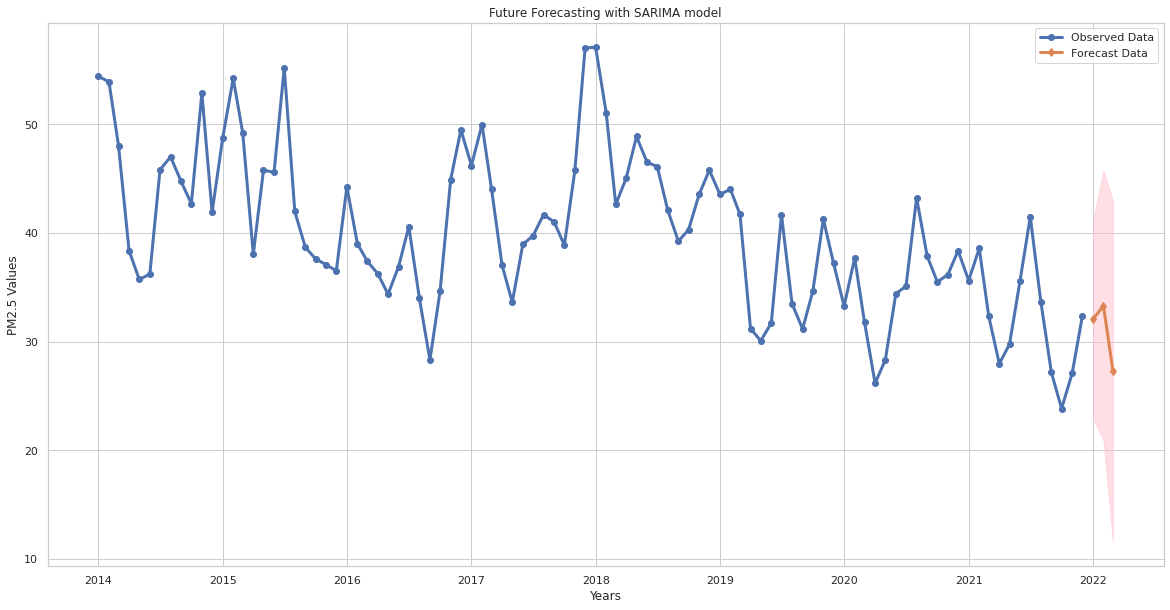

In [ ]:
# plot forecasting
plt.figure(figsize=(20,10))
plt.plot(df_models_m.index, df_models_m.pm25, label='Observed Data', marker='o', linewidth=3)
plt.plot(mean_forecast.index[-3:], mean_forecast.values[-3:], label='Forecast Data', marker='d', linewidth=3)
plt.fill_between(confidence_intervals[-3:].index, confidence_intervals['upper pm25'][-3:],
    confidence_intervals['lower pm25'][-3:], color='pink', alpha=0.5, edgecolor=(0,0,0,.6))
plt.legend(loc='best')
plt.title('Future Forecasting with SARIMA model')
plt.xlabel('Years')
plt.ylabel('PM2.5 Values')


# Add months between years
plt.show()

**Same plot with months in x-axis**

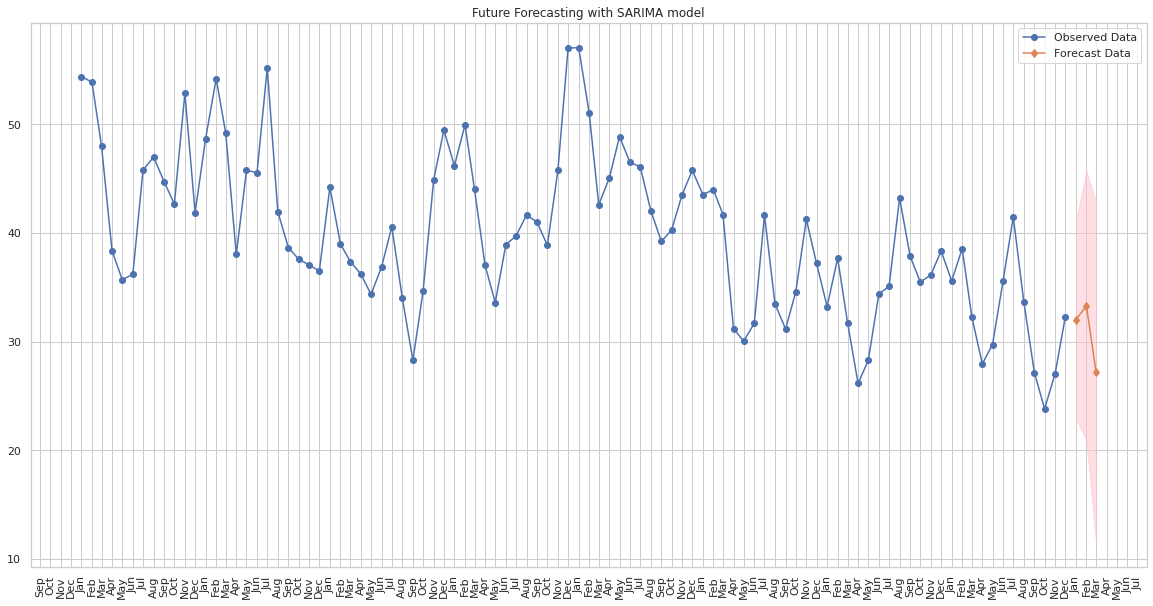

In [ ]:
import matplotlib.dates as mdates
import datetime

plt.figure(figsize=(20,10))
# Generate some random date-time data
numdays = 500
y = np.random.rand(numdays)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

# Plot observed data, forecast data with confidence intervals 
plt.plot(df_models_m.index, df_models_m.pm25, label='Observed Data', marker='o')
plt.plot(mean_forecast.index[-3:], mean_forecast.values[-3:], label='Forecast Data', marker='d')
plt.fill_between(confidence_intervals[-3:].index, confidence_intervals['upper pm25'][-3:],
    confidence_intervals['lower pm25'][-3:], color='pink', alpha=0.5, edgecolor=(0,0,0,.5))
plt.legend(loc='best')
plt.title('Future Forecasting with SARIMA model')

# put months
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation=90)
plt.show()